<a href="https://colab.research.google.com/github/ArezaB/Reza/blob/main/FFA_single_station.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Flood Frequency Analysis for one station**

In [6]:
from google.colab import files

# Upload the CSV file
uploaded = files.upload()

Saving 02GD027_PEAK.csv to 02GD027_PEAK (1).csv


Enter the flow threshold: 15
Choose a distribution (log_pearson/gev/weibull/log_normal/pearson3): gev


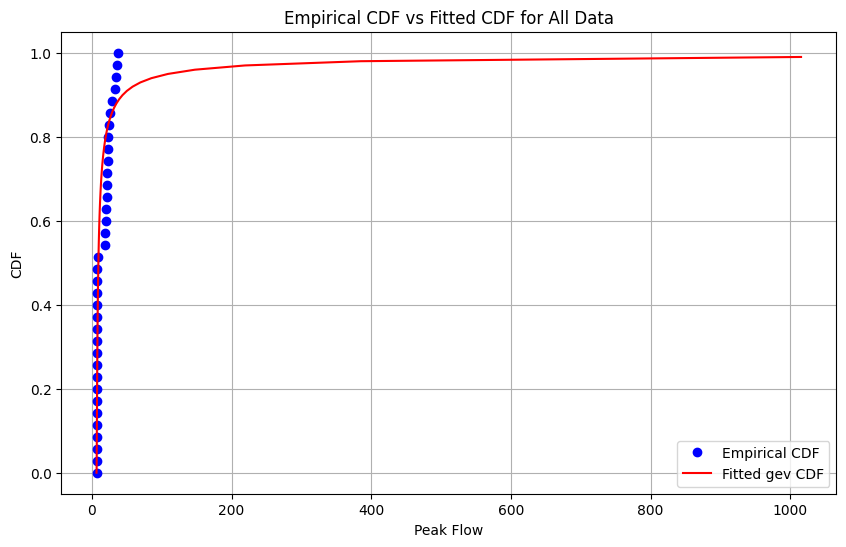

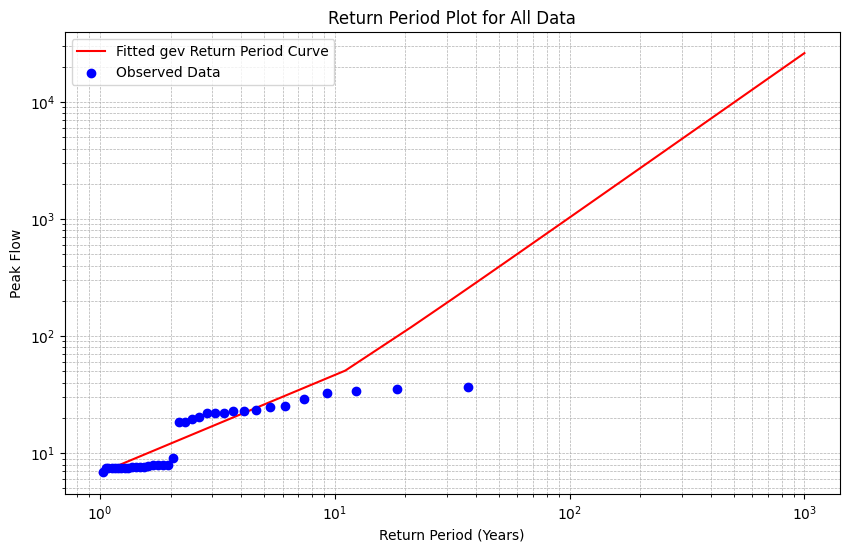

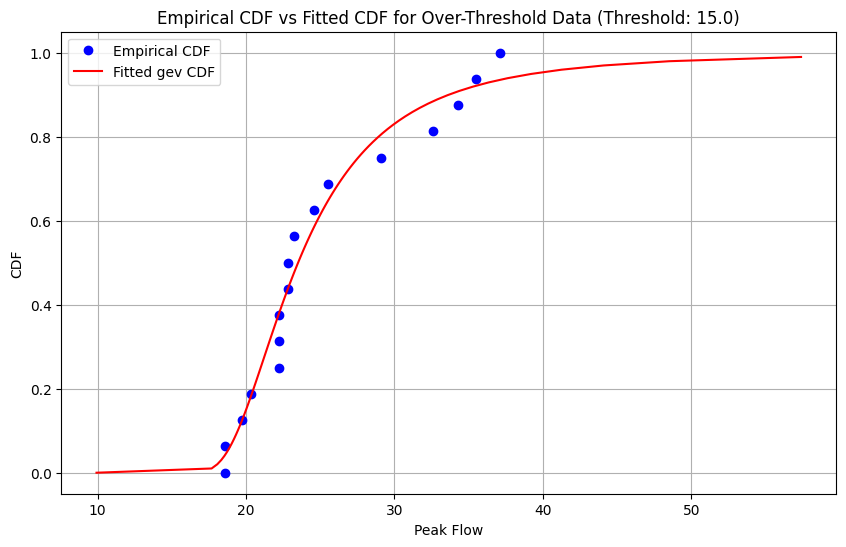

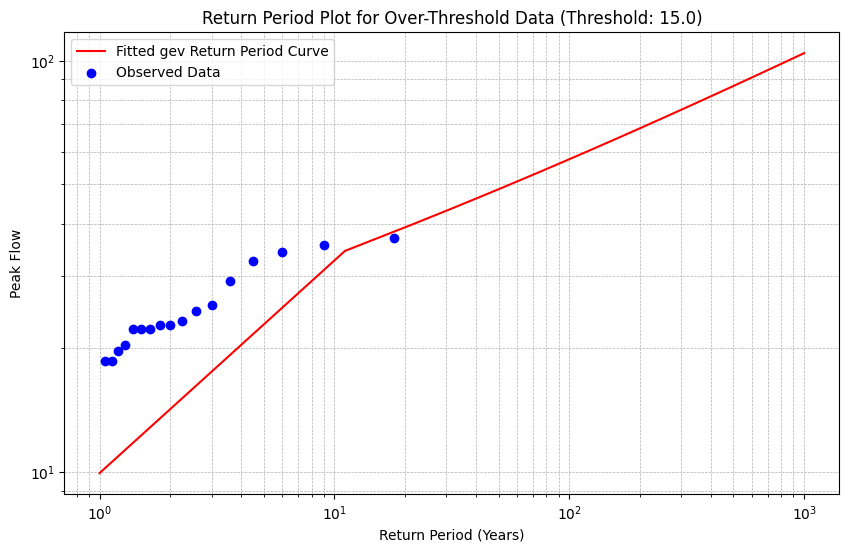

Enter the return period for which you want the peak value: 250
Estimated peak value for return period 250.0 (All Data): 3725.9625555839743
Estimated peak value for return period 250.0 (Over-Threshold Data): 72.4522960749839

Goodness of Fit (Kolmogorov-Smirnov Test) for All Data:
KS Statistic: nan, P-value: nan

Goodness of Fit (Kolmogorov-Smirnov Test) for Over-Threshold Data:
KS Statistic: nan, P-value: nan


In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearson3, genextreme, weibull_min, lognorm, kstest

# Step 1: Load the dataset
file_path = '/content/02GD027_PEAK.csv'  # Update path if necessary
df = pd.read_csv(file_path)

# Step 2: Filter relevant data (Peak Flows)
df_peaks = df[df['PEAK_CODE'] == 'H'][['YEAR', 'PEAK']]

# Step 3: Choose a flow threshold
flow_threshold = float(input("Enter the flow threshold: "))

# Select values that are above the threshold
df_pot = df_peaks[df_peaks['PEAK'] > flow_threshold]

# Step 4: Function to fit the distribution and return the fitted values
def fit_distribution(data, dist_type):
    if dist_type == 'log_pearson':
        log_data = np.log(data)
        params = pearson3.fit(log_data)
        fitted_dist = lambda p: np.exp(pearson3.ppf(p, *params))
    elif dist_type == 'gev':
        params = genextreme.fit(data)
        fitted_dist = lambda p: genextreme.ppf(p, *params)
    elif dist_type == 'weibull':
        params = weibull_min.fit(data)
        fitted_dist = lambda p: weibull_min.ppf(p, *params)
    elif dist_type == 'log_normal':
        params = lognorm.fit(data)
        fitted_dist = lambda p: lognorm.ppf(p, *params)
    elif dist_type == 'pearson3':
        params = pearson3.fit(data)
        fitted_dist = lambda p: pearson3.ppf(p, *params)
    else:
        raise ValueError("Invalid distribution type!")

    return fitted_dist, params

# Step 5: Select distribution and fit
distribution_choice = input("Choose a distribution (log_pearson/gev/weibull/log_normal/pearson3): ")

# Fit distributions for both datasets (all data and over-threshold)
dist_all, params_all = fit_distribution(df_peaks['PEAK'], distribution_choice)
dist_pot, params_pot = fit_distribution(df_pot['PEAK'], distribution_choice)

# Step 6: Function to plot data vs fitted distribution
def plot_distribution(data, dist, title):
    plt.figure(figsize=(10, 6))
    sorted_data = np.sort(data)
    cdf_empirical = np.linspace(0, 1, len(sorted_data))
    plt.plot(sorted_data, cdf_empirical, 'bo', label='Empirical CDF')

    x = np.linspace(sorted_data.min(), sorted_data.max(), 100)
    fitted_cdf = dist(np.linspace(0, 1, 100))
    plt.plot(fitted_cdf, np.linspace(0, 1, 100), 'r-', label=f'Fitted {distribution_choice} CDF')

    plt.xlabel('Peak Flow')
    plt.ylabel('CDF')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Step 7: Function to plot peak values vs return periods
def plot_return_period_with_observations(data, dist, title):
    return_periods = np.linspace(1, 1000, 100)
    peaks = dist(1 - 1/return_periods)

    # Empirical return periods
    sorted_data = np.sort(data)
    n = len(sorted_data)
    empirical_return_periods = (n + 1) / np.arange(1, n + 1)  # Weibull plotting position

    plt.figure(figsize=(10, 6))
    plt.plot(return_periods, peaks, 'r-', label=f'Fitted {distribution_choice} Return Period Curve')
    plt.scatter(empirical_return_periods[::-1], sorted_data, color='blue', label='Observed Data', zorder=5)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Return Period (Years)')
    plt.ylabel('Peak Flow')
    plt.title(title)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()

# Step 8: Function to calculate goodness-of-fit (Kolmogorov-Smirnov test)
def goodness_of_fit(data, dist):
    sorted_data = np.sort(data)
    empirical_cdf = np.arange(1, len(sorted_data) + 1) / (len(sorted_data) + 1)
    ks_stat, p_value = kstest(sorted_data, dist)
    return ks_stat, p_value

# Step 9: Plot density graphs and return period plots

# 1. Plot empirical CDF and fitted distribution for all data
plot_distribution(df_peaks['PEAK'], dist_all, 'Empirical CDF vs Fitted CDF for All Data')

# 2. Plot return period for all data
plot_return_period_with_observations(df_peaks['PEAK'], dist_all, 'Return Period Plot for All Data')

# 3. Plot empirical CDF and fitted distribution for over-threshold data
plot_distribution(df_pot['PEAK'], dist_pot, f'Empirical CDF vs Fitted CDF for Over-Threshold Data (Threshold: {flow_threshold})')

# 4. Plot return period for over-threshold data
plot_return_period_with_observations(df_pot['PEAK'], dist_pot, f'Return Period Plot for Over-Threshold Data (Threshold: {flow_threshold})')

# Step 10: Return period calculation for specific request
requested_return_period = float(input("Enter the return period for which you want the peak value: "))
requested_peak_all = dist_all(1 - 1/requested_return_period)
requested_peak_pot = dist_pot(1 - 1/requested_return_period)

print(f"Estimated peak value for return period {requested_return_period} (All Data): {requested_peak_all}")
print(f"Estimated peak value for return period {requested_return_period} (Over-Threshold Data): {requested_peak_pot}")

# Step 11: Goodness-of-fit calculation for both datasets
ks_stat_all, p_value_all = goodness_of_fit(df_peaks['PEAK'], lambda p: dist_all(p))
ks_stat_pot, p_value_pot = goodness_of_fit(df_pot['PEAK'], lambda p: dist_pot(p))

print(f"\nGoodness of Fit (Kolmogorov-Smirnov Test) for All Data:")
print(f"KS Statistic: {ks_stat_all}, P-value: {p_value_all}")

print(f"\nGoodness of Fit (Kolmogorov-Smirnov Test) for Over-Threshold Data:")
print(f"KS Statistic: {ks_stat_pot}, P-value: {p_value_pot}")


In [10]:
print(df_peaks['PEAK'].isna().sum())
print(np.isfinite(df_peaks['PEAK']).sum())


0
36


In [11]:
print(df_pot.describe())
print(len(df_pot))


              YEAR       PEAK
count    17.000000  17.000000
mean   2012.823529  25.370588
std       6.366271   6.043257
min    2003.000000  18.600000
25%    2007.000000  22.200001
50%    2014.000000  22.799999
75%    2018.000000  29.100000
max    2022.000000  37.099998
17


In [12]:
print(params_all)
print(params_pot)


(-1.4041552836077322, 8.359099497203697, 2.249089907379405)
(-0.29629214936016246, 22.108085591062657, 3.6105717675154887)


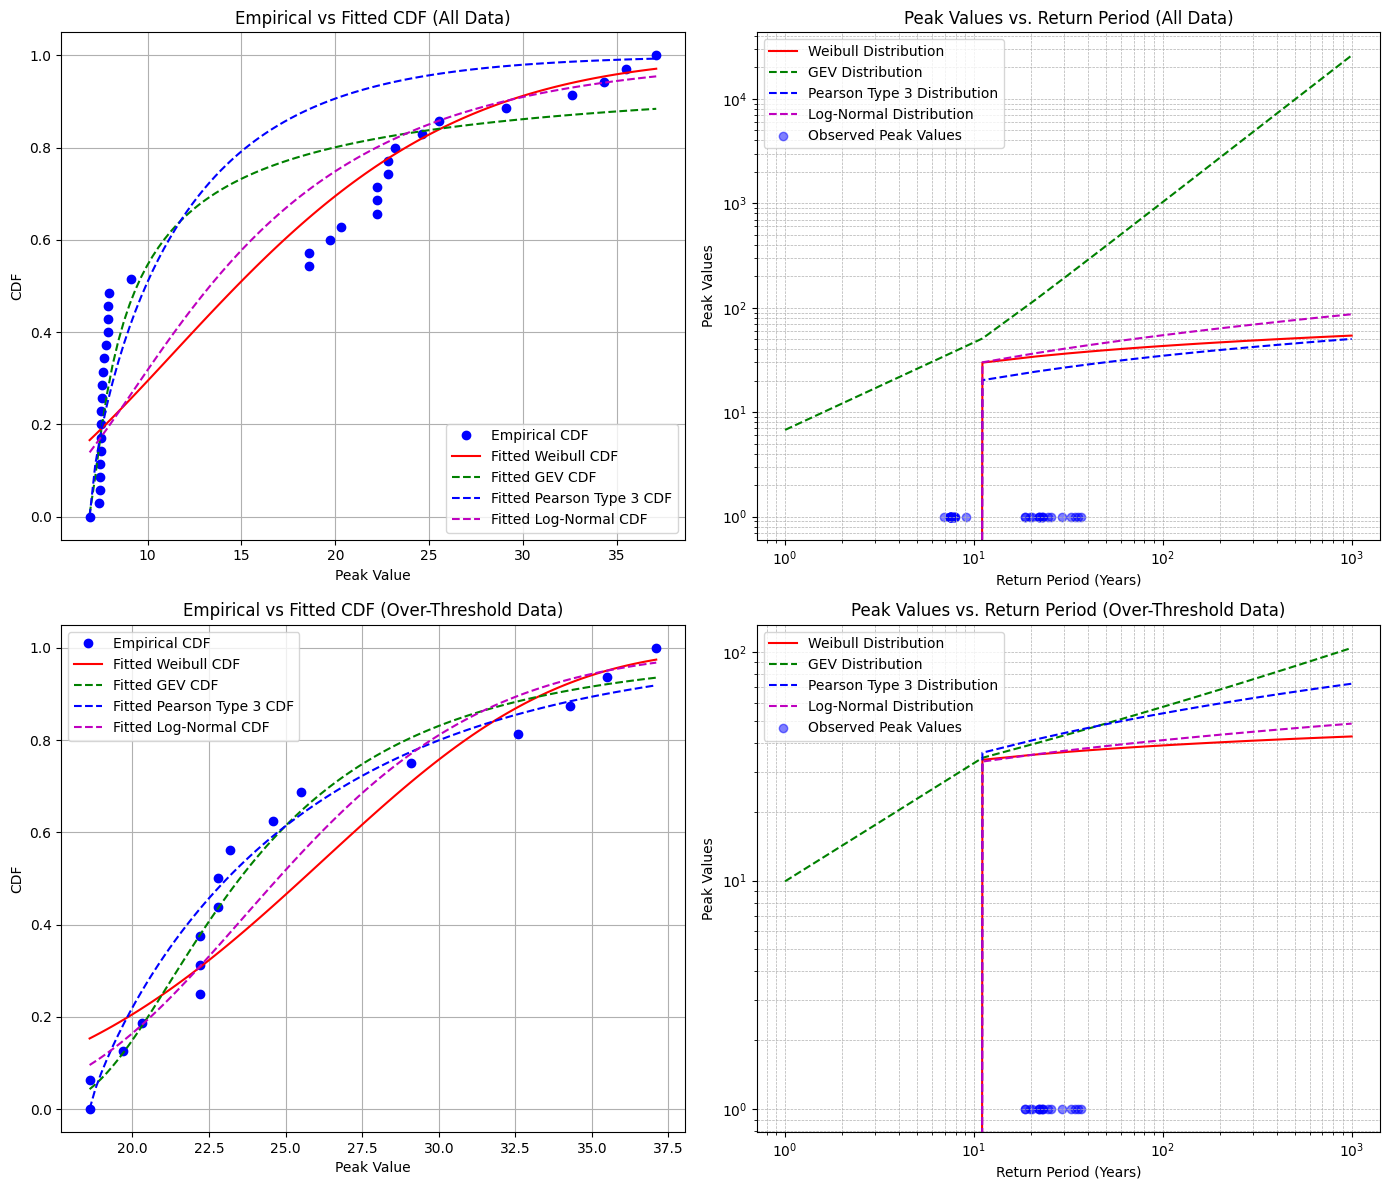

Peak Flow for 250-Year Return Period (All Data):
Weibull Distribution: 47.67
GEV Distribution: 3725.96
Pearson Type 3 Distribution: 40.85
Log-Normal Distribution: 66.42

Peak Flow for 250-Year Return Period (Over-Threshold Data):
Weibull Distribution: 40.63
GEV Distribution: 72.45
Pearson Type 3 Distribution: 61.35
Log-Normal Distribution: 44.18


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme, weibull_min, lognorm, pearson3, kstest
from scipy.optimize import curve_fit

# Load the dataset
file_path = '/content/02GD027_PEAK.csv'  # Update path if necessary
df = pd.read_csv(file_path)

# Filter relevant data (Peak Flows)
df_peaks = df[df['PEAK_CODE'] == 'H'][['YEAR', 'PEAK']]

# Define the threshold for Peak Over Threshold (POT)
threshold = 15  # Example threshold, adjust as needed
df_pot = df_peaks[df_peaks['PEAK'] > threshold]

# Fit distributions
# Weibull
params_weibull_all = weibull_min.fit(df_peaks['PEAK'], floc=0)
params_weibull_pot = weibull_min.fit(df_pot['PEAK'], floc=0)

# GEV
params_gev_all = genextreme.fit(df_peaks['PEAK'])
params_gev_pot = genextreme.fit(df_pot['PEAK'])

# Pearson Type 3
params_pearson3_all = pearson3.fit(df_peaks['PEAK'])
params_pearson3_pot = pearson3.fit(df_pot['PEAK'])

# Log-Pearson Type 3 (Transform data before fitting)
log_peaks_all = np.log(df_peaks['PEAK'])
log_peaks_pot = np.log(df_pot['PEAK'])
params_log_pearson3_all = pearson3.fit(log_peaks_all)
params_log_pearson3_pot = pearson3.fit(log_peaks_pot)

# Log-Normal 3 parameters
params_lognorm_all = lognorm.fit(df_peaks['PEAK'], floc=0)
params_lognorm_pot = lognorm.fit(df_pot['PEAK'], floc=0)

# Goodness-of-fit tests (Kolmogorov-Smirnov Test)
# Weibull
ks_stat_weibull_all, ks_pval_weibull_all = kstest(df_peaks['PEAK'], weibull_min.cdf, args=params_weibull_all)
ks_stat_weibull_pot, ks_pval_weibull_pot = kstest(df_pot['PEAK'], weibull_min.cdf, args=params_weibull_pot)

# GEV
ks_stat_gev_all, ks_pval_gev_all = kstest(df_peaks['PEAK'], genextreme.cdf, args=params_gev_all)
ks_stat_gev_pot, ks_pval_gev_pot = kstest(df_pot['PEAK'], genextreme.cdf, args=params_gev_pot)

# Pearson Type 3
ks_stat_pearson3_all, ks_pval_pearson3_all = kstest(df_peaks['PEAK'], pearson3.cdf, args=params_pearson3_all)
ks_stat_pearson3_pot, ks_pval_pearson3_pot = kstest(df_pot['PEAK'], pearson3.cdf, args=params_pearson3_pot)

# Log-Pearson Type 3
def log_pearson3_cdf(x, skew, loc, scale):
    # Custom CDF function for Log-Pearson Type 3
    return pearson3.cdf(np.log(x), skew, loc, scale)

ks_stat_log_pearson3_all, ks_pval_log_pearson3_all = kstest(df_peaks['PEAK'], log_pearson3_cdf, args=params_log_pearson3_all)
ks_stat_log_pearson3_pot, ks_pval_log_pearson3_pot = kstest(df_pot['PEAK'], log_pearson3_cdf, args=params_log_pearson3_pot)

# Log-Normal
ks_stat_lognorm_all, ks_pval_lognorm_all = kstest(df_peaks['PEAK'], lognorm.cdf, args=params_lognorm_all)
ks_stat_lognorm_pot, ks_pval_lognorm_pot = kstest(df_pot['PEAK'], lognorm.cdf, args=params_lognorm_pot)

# Plotting
plt.figure(figsize=(14, 12))

# 1. Plot the data and fitted distribution
plt.subplot(2, 2, 1)
sorted_peaks = np.sort(df_peaks['PEAK'])
cdf_empirical_all = np.linspace(0, 1, len(sorted_peaks))
plt.plot(sorted_peaks, cdf_empirical_all, 'bo', label='Empirical CDF')
x = np.linspace(sorted_peaks.min(), sorted_peaks.max(), 100)
plt.plot(x, weibull_min.cdf(x, *params_weibull_all), 'r-', label='Fitted Weibull CDF')
plt.plot(x, genextreme.cdf(x, *params_gev_all), 'g--', label='Fitted GEV CDF')
plt.plot(x, pearson3.cdf(x, *params_pearson3_all), 'b--', label='Fitted Pearson Type 3 CDF')
plt.plot(x, lognorm.cdf(x, *params_lognorm_all), 'm--', label='Fitted Log-Normal CDF')
plt.xlabel('Peak Value')
plt.ylabel('CDF')
plt.title('Empirical vs Fitted CDF (All Data)')
plt.legend()
plt.grid(True)

# 2. Plot the Peak Values vs. Return Periods
return_periods = np.linspace(1, 1000, 100)
peaks_weibull_all = weibull_min.ppf(1 - 1/return_periods, *params_weibull_all)
peaks_gev_all = genextreme.ppf(1 - 1/return_periods, *params_gev_all)
peaks_pearson3_all = pearson3.ppf(1 - 1/return_periods, *params_pearson3_all)
peaks_lognorm_all = lognorm.ppf(1 - 1/return_periods, *params_lognorm_all)

plt.subplot(2, 2, 2)
plt.plot(return_periods, peaks_weibull_all, 'r-', label='Weibull Distribution')
plt.plot(return_periods, peaks_gev_all, 'g--', label='GEV Distribution')
plt.plot(return_periods, peaks_pearson3_all, 'b--', label='Pearson Type 3 Distribution')
plt.plot(return_periods, peaks_lognorm_all, 'm--', label='Log-Normal Distribution')
plt.scatter(df_peaks['PEAK'], [1] * len(df_peaks), color='blue', marker='o', label='Observed Peak Values', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Return Period (Years)')
plt.ylabel('Peak Values')
plt.title('Peak Values vs. Return Period (All Data)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 3. Plot empirical CDF and fitted CDF (Over-Threshold Data)
plt.subplot(2, 2, 3)
sorted_peaks_pot = np.sort(df_pot['PEAK'])
cdf_empirical_pot = np.linspace(0, 1, len(sorted_peaks_pot))
plt.plot(sorted_peaks_pot, cdf_empirical_pot, 'bo', label='Empirical CDF')
x_pot = np.linspace(sorted_peaks_pot.min(), sorted_peaks_pot.max(), 100)
plt.plot(x_pot, weibull_min.cdf(x_pot, *params_weibull_pot), 'r-', label='Fitted Weibull CDF')
plt.plot(x_pot, genextreme.cdf(x_pot, *params_gev_pot), 'g--', label='Fitted GEV CDF')
plt.plot(x_pot, pearson3.cdf(x_pot, *params_pearson3_pot), 'b--', label='Fitted Pearson Type 3 CDF')
plt.plot(x_pot, lognorm.cdf(x_pot, *params_lognorm_pot), 'm--', label='Fitted Log-Normal CDF')
plt.xlabel('Peak Value')
plt.ylabel('CDF')
plt.title('Empirical vs Fitted CDF (Over-Threshold Data)')
plt.legend()
plt.grid(True)

# 4. Plot Peak Values vs. Return Period (Over-Threshold Data)
return_periods_pot = np.linspace(1, 1000, 100)
peaks_weibull_pot = weibull_min.ppf(1 - 1/return_periods_pot, *params_weibull_pot)
peaks_gev_pot = genextreme.ppf(1 - 1/return_periods_pot, *params_gev_pot)
peaks_pearson3_pot = pearson3.ppf(1 - 1/return_periods_pot, *params_pearson3_pot)
peaks_lognorm_pot = lognorm.ppf(1 - 1/return_periods_pot, *params_lognorm_pot)

plt.subplot(2, 2, 4)
plt.plot(return_periods_pot, peaks_weibull_pot, 'r-', label='Weibull Distribution')
plt.plot(return_periods_pot, peaks_gev_pot, 'g--', label='GEV Distribution')
plt.plot(return_periods_pot, peaks_pearson3_pot, 'b--', label='Pearson Type 3 Distribution')
plt.plot(return_periods_pot, peaks_lognorm_pot, 'm--', label='Log-Normal Distribution')
plt.scatter(df_pot['PEAK'], [1] * len(df_pot), color='blue', marker='o', label='Observed Peak Values', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Return Period (Years)')
plt.ylabel('Peak Values')
plt.title('Peak Values vs. Return Period (Over-Threshold Data)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Return Peak Flow for 250-year Return Period
return_period = 250

# All Data
peak_weibull_250_all = weibull_min.ppf(1 - 1/return_period, *params_weibull_all)
peak_gev_250_all = genextreme.ppf(1 - 1/return_period, *params_gev_all)
peak_pearson3_250_all = pearson3.ppf(1 - 1/return_period, *params_pearson3_all)
peak_lognorm_250_all = lognorm.ppf(1 - 1/return_period, *params_lognorm_all)

# Over-Threshold Data
peak_weibull_250_pot = weibull_min.ppf(1 - 1/return_period, *params_weibull_pot)
peak_gev_250_pot = genextreme.ppf(1 - 1/return_period, *params_gev_pot)
peak_pearson3_250_pot = pearson3.ppf(1 - 1/return_period, *params_pearson3_pot)
peak_lognorm_250_pot = lognorm.ppf(1 - 1/return_period, *params_lognorm_pot)

print("Peak Flow for 250-Year Return Period (All Data):")
print(f"Weibull Distribution: {peak_weibull_250_all:.2f}")
print(f"GEV Distribution: {peak_gev_250_all:.2f}")
print(f"Pearson Type 3 Distribution: {peak_pearson3_250_all:.2f}")
print(f"Log-Normal Distribution: {peak_lognorm_250_all:.2f}")

print("\nPeak Flow for 250-Year Return Period (Over-Threshold Data):")
print(f"Weibull Distribution: {peak_weibull_250_pot:.2f}")
print(f"GEV Distribution: {peak_gev_250_pot:.2f}")
print(f"Pearson Type 3 Distribution: {peak_pearson3_250_pot:.2f}")
print(f"Log-Normal Distribution: {peak_lognorm_250_pot:.2f}")


In [8]:
!pip install lmoments3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.1 MB/s eta 0:00:00


In [9]:
# Required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genextreme, weibull_min, pearson3, lognorm, kstest
from scipy.stats import norm
from lmoments3 import distr

# Load your data
file_path = '/content/02GD027_PEAK.csv'  # Corrected file path and name
df_peaks = pd.read_csv(file_path)

# Select POT (peaks over threshold)
threshold = 10  # Modify this as needed
df_pot = df_peaks[df_peaks['PEAK'] > threshold]

# Fit distributions (All Data)
params_weibull_all = weibull_min.fit(df_peaks['PEAK'])
params_gev_all = genextreme.fit(df_peaks['PEAK'])
params_pearson3_all = pearson3.fit(df_peaks['PEAK'])
params_lognorm_all = lognorm.fit(df_peaks['PEAK'])

# Log-Pearson Type III using L-moments (All Data)
lms_all = distr.pe3.lmom_fit(df_peaks['PEAK'])

# Fit distributions (Over-Threshold Data)
params_weibull_pot = weibull_min.fit(df_pot['PEAK'])
params_gev_pot = genextreme.fit(df_pot['PEAK'])
params_pearson3_pot = pearson3.fit(df_pot['PEAK'])
params_lognorm_pot = lognorm.fit(df_pot['PEAK'])

# Log-Pearson Type III using L-moments (POT Data)
lms_pot = distr.pe3.lmom_fit(df_pot['PEAK'])

# Goodness-of-fit tests (Kolmogorov-Smirnov Test)
# Weibull
ks_stat_weibull_all, ks_pval_weibull_all = kstest(df_peaks['PEAK'], weibull_min.cdf, args=params_weibull_all)
ks_stat_weibull_pot, ks_pval_weibull_pot = kstest(df_pot['PEAK'], weibull_min.cdf, args=params_weibull_pot)

# GEV
ks_stat_gev_all, ks_pval_gev_all = kstest(df_peaks['PEAK'], genextreme.cdf, args=params_gev_all)
ks_stat_gev_pot, ks_pval_gev_pot = kstest(df_pot['PEAK'], genextreme.cdf, args=params_gev_pot)

# Pearson Type 3
ks_stat_pearson3_all, ks_pval_pearson3_all = kstest(df_peaks['PEAK'], pearson3.cdf, args=params_pearson3_all)
ks_stat_pearson3_pot, ks_pval_pearson3_pot = kstest(df_pot['PEAK'], pearson3.cdf, args=params_pearson3_pot)

# Log-Normal
ks_stat_lognorm_all, ks_pval_lognorm_all = kstest(df_peaks['PEAK'], lognorm.cdf, args=params_lognorm_all)
ks_stat_lognorm_pot, ks_pval_lognorm_pot = kstest(df_pot['PEAK'], lognorm.cdf, args=params_lognorm_pot)

# Display the results
print(f"Weibull K-S Test (All Data): Statistic={ks_stat_weibull_all:.4f}, p-value={ks_pval_weibull_all:.4f}")
print(f"Weibull K-S Test (POT Data): Statistic={ks_stat_weibull_pot:.4f}, p-value={ks_pval_weibull_pot:.4f}")

print(f"GEV K-S Test (All Data): Statistic={ks_stat_gev_all:.4f}, p-value={ks_pval_gev_all:.4f}")
print(f"GEV K-S Test (POT Data): Statistic={ks_stat_gev_pot:.4f}, p-value={ks_pval_gev_pot:.4f}")

print(f"Pearson Type 3 K-S Test (All Data): Statistic={ks_stat_pearson3_all:.4f}, p-value={ks_pval_pearson3_all:.4f}")
print(f"Pearson Type 3 K-S Test (POT Data): Statistic={ks_stat_pearson3_pot:.4f}, p-value={ks_pval_pearson3_pot:.4f}")

print(f"Log-Normal K-S Test (All Data): Statistic={ks_stat_lognorm_all:.4f}, p-value={ks_pval_lognorm_all:.4f}")
print(f"Log-Normal K-S Test (POT Data): Statistic={ks_stat_lognorm_pot:.4f}, p-value={ks_pval_lognorm_pot:.4f}")

# Log-Pearson Type III parameters
print(f"Log-Pearson Type III (All Data) Params: {lms_all}")
print(f"Log-Pearson Type III (POT Data) Params: {lms_pot}")


Weibull K-S Test (All Data): Statistic=0.3719, p-value=0.0000
Weibull K-S Test (POT Data): Statistic=0.1830, p-value=0.5584
GEV K-S Test (All Data): Statistic=0.2115, p-value=0.0038
GEV K-S Test (POT Data): Statistic=0.1419, p-value=0.8371
Pearson Type 3 K-S Test (All Data): Statistic=0.4237, p-value=0.0000
Pearson Type 3 K-S Test (POT Data): Statistic=0.1988, p-value=0.4544
Log-Normal K-S Test (All Data): Statistic=0.2391, p-value=0.0007
Log-Normal K-S Test (POT Data): Statistic=0.4690, p-value=0.0006
Log-Pearson Type III (All Data) Params: OrderedDict([('skew', 1.9596597928381652), ('loc', 9.940441163530682), ('scale', 10.035986833132801)])
Log-Pearson Type III (POT Data) Params: OrderedDict([('skew', 1.6125742362075066), ('loc', 25.370588190415326), ('scale', 6.467382678337644)])


In [16]:
# Log-Pearson Type 3 (for return period)
peak_log_pearson3_250_all = np.exp(pearson3.ppf(1 - 1/return_period, *params_log_pearson3_all))
peak_log_pearson3_250_pot = np.exp(pearson3.ppf(1 - 1/return_period, *params_log_pearson3_pot))

# Print the results for 250-year return period (including Log-Pearson Type 3)
print(f"Log-Pearson Type 3 Distribution (All Data): {peak_log_pearson3_250_all:.2f}")
print(f"Log-Pearson Type 3 Distribution (Over-Threshold Data): {peak_log_pearson3_250_pot:.2f}")


Log-Pearson Type 3 Distribution (All Data): 217.26
Log-Pearson Type 3 Distribution (Over-Threshold Data): 94.33


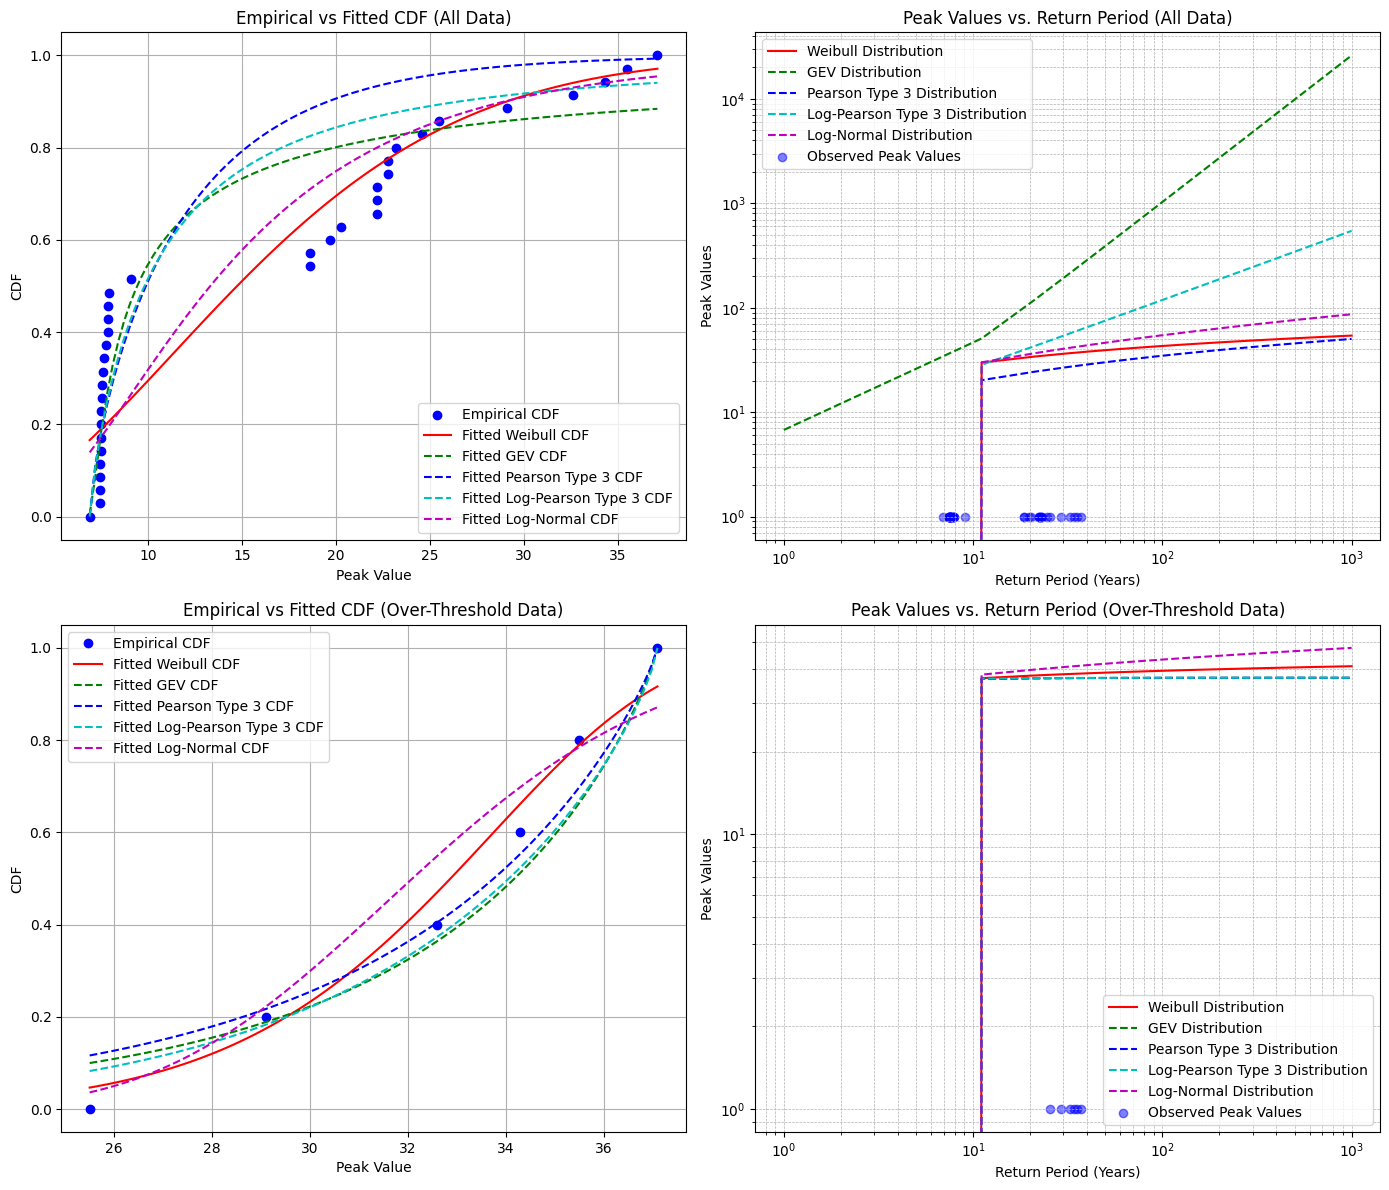

Weibull (All Data): K-S Statistic = 0.2934, P-Value = 0.0031
GEV (All Data): K-S Statistic = 0.2584, P-Value = 0.0131
Pearson Type 3 (All Data): K-S Statistic = 0.3555, P-Value = 0.0001
Log-Pearson Type 3 (All Data): K-S Statistic = 0.2969, P-Value = 0.0026
Log-Normal (All Data): K-S Statistic = 0.3040, P-Value = 0.0019
Weibull (Over-Threshold Data): K-S Statistic = 0.1621, P-Value = 0.9890
GEV (Over-Threshold Data): K-S Statistic = 0.1702, P-Value = 0.9811
Pearson Type 3 (Over-Threshold Data): K-S Statistic = 0.1667, P-Value = 0.9846
Log-Pearson Type 3 (Over-Threshold Data): K-S Statistic = 0.1667, P-Value = 0.9846
Log-Normal (Over-Threshold Data): K-S Statistic = 0.2153, P-Value = 0.8926
250-year Return Period Estimates (All Data):
Weibull: 47.67
GEV: 3725.96
Pearson Type 3: 40.85
Log-Pearson Type 3: 217.26
Log-Normal: 66.42
250-year Return Period Estimates (Over-Threshold Data):
Weibull: 40.02
GEV: 37.09
Pearson Type 3: 37.09
Log-Pearson Type 3: 37.10
Log-Normal: 45.07


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme, weibull_min, lognorm, pearson3, kstest
from scipy.optimize import curve_fit

# Load the dataset
file_path = '/content/02GD027_PEAK.csv'  # Update path if necessary
df = pd.read_csv(file_path)

# Filter relevant data (Peak Flows)
df_peaks = df[df['PEAK_CODE'] == 'H'][['YEAR', 'PEAK']]

# Define the threshold for Peak Over Threshold (POT)
threshold = 25  # Example threshold, adjust as needed
df_pot = df_peaks[df_peaks['PEAK'] > threshold]

# Fit distributions
# Weibull
params_weibull_all = weibull_min.fit(df_peaks['PEAK'], floc=0)
params_weibull_pot = weibull_min.fit(df_pot['PEAK'], floc=0)

# GEV
params_gev_all = genextreme.fit(df_peaks['PEAK'])
params_gev_pot = genextreme.fit(df_pot['PEAK'])

# Pearson Type 3
params_pearson3_all = pearson3.fit(df_peaks['PEAK'])
params_pearson3_pot = pearson3.fit(df_pot['PEAK'])

# Log-Pearson Type 3 (Transform data before fitting)
log_peaks_all = np.log(df_peaks['PEAK'])
log_peaks_pot = np.log(df_pot['PEAK'])
params_log_pearson3_all = pearson3.fit(log_peaks_all)
params_log_pearson3_pot = pearson3.fit(log_peaks_pot)

# Log-Normal 3 parameters
params_lognorm_all = lognorm.fit(df_peaks['PEAK'], floc=0)
params_lognorm_pot = lognorm.fit(df_pot['PEAK'], floc=0)

# Goodness-of-fit tests (Kolmogorov-Smirnov Test)
# Weibull
ks_stat_weibull_all, ks_pval_weibull_all = kstest(df_peaks['PEAK'], weibull_min.cdf, args=params_weibull_all)
ks_stat_weibull_pot, ks_pval_weibull_pot = kstest(df_pot['PEAK'], weibull_min.cdf, args=params_weibull_pot)

# GEV
ks_stat_gev_all, ks_pval_gev_all = kstest(df_peaks['PEAK'], genextreme.cdf, args=params_gev_all)
ks_stat_gev_pot, ks_pval_gev_pot = kstest(df_pot['PEAK'], genextreme.cdf, args=params_gev_pot)

# Pearson Type 3
ks_stat_pearson3_all, ks_pval_pearson3_all = kstest(df_peaks['PEAK'], pearson3.cdf, args=params_pearson3_all)
ks_stat_pearson3_pot, ks_pval_pearson3_pot = kstest(df_pot['PEAK'], pearson3.cdf, args=params_pearson3_pot)

# Log-Pearson Type 3
def log_pearson3_cdf(x, skew, loc, scale):
    # Custom CDF function for Log-Pearson Type 3
    return pearson3.cdf(np.log(x), skew, loc, scale)

ks_stat_log_pearson3_all, ks_pval_log_pearson3_all = kstest(df_peaks['PEAK'], log_pearson3_cdf, args=params_log_pearson3_all)
ks_stat_log_pearson3_pot, ks_pval_log_pearson3_pot = kstest(df_pot['PEAK'], log_pearson3_cdf, args=params_log_pearson3_pot)

# Log-Normal
ks_stat_lognorm_all, ks_pval_lognorm_all = kstest(df_peaks['PEAK'], lognorm.cdf, args=params_lognorm_all)
ks_stat_lognorm_pot, ks_pval_lognorm_pot = kstest(df_pot['PEAK'], lognorm.cdf, args=params_lognorm_pot)

# Plotting
plt.figure(figsize=(14, 12))

# 1. Plot the data and fitted distribution
plt.subplot(2, 2, 1)
sorted_peaks = np.sort(df_peaks['PEAK'])
cdf_empirical_all = np.linspace(0, 1, len(sorted_peaks))
plt.plot(sorted_peaks, cdf_empirical_all, 'bo', label='Empirical CDF')
x = np.linspace(sorted_peaks.min(), sorted_peaks.max(), 100)
plt.plot(x, weibull_min.cdf(x, *params_weibull_all), 'r-', label='Fitted Weibull CDF')
plt.plot(x, genextreme.cdf(x, *params_gev_all), 'g--', label='Fitted GEV CDF')
plt.plot(x, pearson3.cdf(x, *params_pearson3_all), 'b--', label='Fitted Pearson Type 3 CDF')
plt.plot(x, log_pearson3_cdf(x, *params_log_pearson3_all), 'c--', label='Fitted Log-Pearson Type 3 CDF')
plt.plot(x, lognorm.cdf(x, *params_lognorm_all), 'm--', label='Fitted Log-Normal CDF')
plt.xlabel('Peak Value')
plt.ylabel('CDF')
plt.title('Empirical vs Fitted CDF (All Data)')
plt.legend()
plt.grid(True)

# 2. Plot the Peak Values vs. Return Periods
return_periods = np.linspace(1, 1000, 100)
peaks_weibull_all = weibull_min.ppf(1 - 1/return_periods, *params_weibull_all)
peaks_gev_all = genextreme.ppf(1 - 1/return_periods, *params_gev_all)
peaks_pearson3_all = pearson3.ppf(1 - 1/return_periods, *params_pearson3_all)
peaks_log_pearson3_all = np.exp(pearson3.ppf(1 - 1/return_periods, *params_log_pearson3_all))
peaks_lognorm_all = lognorm.ppf(1 - 1/return_periods, *params_lognorm_all)

plt.subplot(2, 2, 2)
plt.plot(return_periods, peaks_weibull_all, 'r-', label='Weibull Distribution')
plt.plot(return_periods, peaks_gev_all, 'g--', label='GEV Distribution')
plt.plot(return_periods, peaks_pearson3_all, 'b--', label='Pearson Type 3 Distribution')
plt.plot(return_periods, peaks_log_pearson3_all, 'c--', label='Log-Pearson Type 3 Distribution')
plt.plot(return_periods, peaks_lognorm_all, 'm--', label='Log-Normal Distribution')
plt.scatter(df_peaks['PEAK'], [1] * len(df_peaks), color='blue', marker='o', label='Observed Peak Values', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Return Period (Years)')
plt.ylabel('Peak Values')
plt.title('Peak Values vs. Return Period (All Data)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 3. Plot empirical CDF and fitted CDF (Over-Threshold Data)
plt.subplot(2, 2, 3)
sorted_peaks_pot = np.sort(df_pot['PEAK'])
cdf_empirical_pot = np.linspace(0, 1, len(sorted_peaks_pot))
plt.plot(sorted_peaks_pot, cdf_empirical_pot, 'bo', label='Empirical CDF')
x_pot = np.linspace(sorted_peaks_pot.min(), sorted_peaks_pot.max(), 100)
plt.plot(x_pot, weibull_min.cdf(x_pot, *params_weibull_pot), 'r-', label='Fitted Weibull CDF')
plt.plot(x_pot, genextreme.cdf(x_pot, *params_gev_pot), 'g--', label='Fitted GEV CDF')
plt.plot(x_pot, pearson3.cdf(x_pot, *params_pearson3_pot), 'b--', label='Fitted Pearson Type 3 CDF')
plt.plot(x_pot, log_pearson3_cdf(x_pot, *params_log_pearson3_pot), 'c--', label='Fitted Log-Pearson Type 3 CDF')
plt.plot(x_pot, lognorm.cdf(x_pot, *params_lognorm_pot), 'm--', label='Fitted Log-Normal CDF')
plt.xlabel('Peak Value')
plt.ylabel('CDF')
plt.title('Empirical vs Fitted CDF (Over-Threshold Data)')
plt.legend()
plt.grid(True)

# 4. Plot Peak Values vs. Return Period (Over-Threshold Data)
return_periods_pot = np.linspace(1, 1000, 100)
peaks_weibull_pot = weibull_min.ppf(1 - 1/return_periods_pot, *params_weibull_pot)
peaks_gev_pot = genextreme.ppf(1 - 1/return_periods_pot, *params_gev_pot)
peaks_pearson3_pot = pearson3.ppf(1 - 1/return_periods_pot, *params_pearson3_pot)
peaks_log_pearson3_pot = np.exp(pearson3.ppf(1 - 1/return_periods_pot, *params_log_pearson3_pot))
peaks_lognorm_pot = lognorm.ppf(1 - 1/return_periods_pot, *params_lognorm_pot)

plt.subplot(2, 2, 4)
plt.plot(return_periods_pot, peaks_weibull_pot, 'r-', label='Weibull Distribution')
plt.plot(return_periods_pot, peaks_gev_pot, 'g--', label='GEV Distribution')
plt.plot(return_periods_pot, peaks_pearson3_pot, 'b--', label='Pearson Type 3 Distribution')
plt.plot(return_periods_pot, peaks_log_pearson3_pot, 'c--', label='Log-Pearson Type 3 Distribution')
plt.plot(return_periods_pot, peaks_lognorm_pot, 'm--', label='Log-Normal Distribution')
plt.scatter(df_pot['PEAK'], [1] * len(df_pot), color='blue', marker='o', label='Observed Peak Values', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Return Period (Years)')
plt.ylabel('Peak Values')
plt.title('Peak Values vs. Return Period (Over-Threshold Data)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Print Goodness-of-Fit Statistics
print(f"Weibull (All Data): K-S Statistic = {ks_stat_weibull_all:.4f}, P-Value = {ks_pval_weibull_all:.4f}")
print(f"GEV (All Data): K-S Statistic = {ks_stat_gev_all:.4f}, P-Value = {ks_pval_gev_all:.4f}")
print(f"Pearson Type 3 (All Data): K-S Statistic = {ks_stat_pearson3_all:.4f}, P-Value = {ks_pval_pearson3_all:.4f}")
print(f"Log-Pearson Type 3 (All Data): K-S Statistic = {ks_stat_log_pearson3_all:.4f}, P-Value = {ks_pval_log_pearson3_all:.4f}")
print(f"Log-Normal (All Data): K-S Statistic = {ks_stat_lognorm_all:.4f}, P-Value = {ks_pval_lognorm_all:.4f}")

print(f"Weibull (Over-Threshold Data): K-S Statistic = {ks_stat_weibull_pot:.4f}, P-Value = {ks_pval_weibull_pot:.4f}")
print(f"GEV (Over-Threshold Data): K-S Statistic = {ks_stat_gev_pot:.4f}, P-Value = {ks_pval_gev_pot:.4f}")
print(f"Pearson Type 3 (Over-Threshold Data): K-S Statistic = {ks_stat_pearson3_pot:.4f}, P-Value = {ks_pval_pearson3_pot:.4f}")
print(f"Log-Pearson Type 3 (Over-Threshold Data): K-S Statistic = {ks_stat_log_pearson3_pot:.4f}, P-Value = {ks_pval_log_pearson3_pot:.4f}")
print(f"Log-Normal (Over-Threshold Data): K-S Statistic = {ks_stat_lognorm_pot:.4f}, P-Value = {ks_pval_lognorm_pot:.4f}")

# Calculate 250-year return period
def return_period_250_years(params_dist, dist, is_log=False):
    if is_log:
        return np.exp(pearson3.ppf(1 - 1/250, *params_dist))
    else:
        return dist.ppf(1 - 1/250, *params_dist)

# All Data
return_period_250_weibull_all = return_period_250_years(params_weibull_all, weibull_min)
return_period_250_gev_all = return_period_250_years(params_gev_all, genextreme)
return_period_250_pearson3_all = return_period_250_years(params_pearson3_all, pearson3)
return_period_250_log_pearson3_all = return_period_250_years(params_log_pearson3_all, pearson3, is_log=True)
return_period_250_lognorm_all = return_period_250_years(params_lognorm_all, lognorm)

# Over-Threshold Data
return_period_250_weibull_pot = return_period_250_years(params_weibull_pot, weibull_min)
return_period_250_gev_pot = return_period_250_years(params_gev_pot, genextreme)
return_period_250_pearson3_pot = return_period_250_years(params_pearson3_pot, pearson3)
return_period_250_log_pearson3_pot = return_period_250_years(params_log_pearson3_pot, pearson3, is_log=True)
return_period_250_lognorm_pot = return_period_250_years(params_lognorm_pot, lognorm)

print(f"250-year Return Period Estimates (All Data):")
print(f"Weibull: {return_period_250_weibull_all:.2f}")
print(f"GEV: {return_period_250_gev_all:.2f}")
print(f"Pearson Type 3: {return_period_250_pearson3_all:.2f}")
print(f"Log-Pearson Type 3: {return_period_250_log_pearson3_all:.2f}")
print(f"Log-Normal: {return_period_250_lognorm_all:.2f}")

print(f"250-year Return Period Estimates (Over-Threshold Data):")
print(f"Weibull: {return_period_250_weibull_pot:.2f}")
print(f"GEV: {return_period_250_gev_pot:.2f}")
print(f"Pearson Type 3: {return_period_250_pearson3_pot:.2f}")
print(f"Log-Pearson Type 3: {return_period_250_log_pearson3_pot:.2f}")
print(f"Log-Normal: {return_period_250_lognorm_pot:.2f}")


# **Shape parameter of GEV**

In [19]:
from scipy.stats import genextreme

# Fit GEV distribution to all data
params_gev_all = genextreme.fit(df_peaks['PEAK'])

# Fit GEV distribution to over-threshold data
params_gev_pot = genextreme.fit(df_pot['PEAK'])

# Extract shape parameters
shape_gev_all = params_gev_all[0]
shape_gev_pot = params_gev_pot[0]

print(f"Shape parameter for GEV (All Data): {shape_gev_all:.2f}")
print(f"Shape parameter for GEV (Over-Threshold Data): {shape_gev_pot:.2f}")


Shape parameter for GEV (All Data): -1.40
Shape parameter for GEV (Over-Threshold Data): -0.30


In [20]:
pip install numpy scipy matplotlib


# **Anderson_Darling Test**


In [24]:
import numpy as np
from scipy import stats

def anderson_darling_test(data, dist_names):
    results = {}
    for dist_name in dist_names:
        if dist_name == 'weibull_min':
            # Weibull distribution test
            params = stats.weibull_min.fit(data, floc=0)
            ad_stat, critical_values, significance_level = stats.anderson(data, dist='weibull_min')
            p_value = np.nan  # Anderson-Darling test does not provide a p-value directly
        elif dist_name == 'gumbel_r':
            # Gumbel distribution test
            params = stats.gumbel_r.fit(data)
            ad_stat, critical_values, significance_level = stats.anderson(data, dist='gumbel_r')
            p_value = np.nan  # Anderson-Darling test does not provide a p-value directly
        elif dist_name == 'expon':
            # Exponential distribution test
            params = stats.expon.fit(data)
            ad_stat, critical_values, significance_level = stats.anderson(data, dist='expon')
            p_value = np.nan  # Anderson-Darling test does not provide a p-value directly
        elif dist_name == 'norm':
            # Normal distribution test
            params = stats.norm.fit(data)
            ad_stat, critical_values, significance_level = stats.anderson(data, dist='norm')
            p_value = np.nan  # Anderson-Darling test does not provide a p-value directly
        elif dist_name == 'logistic':
            # Logistic distribution test
            params = stats.logistic.fit(data)
            ad_stat, critical_values, significance_level = stats.anderson(data, dist='logistic')
            p_value = np.nan  # Anderson-Darling test does not provide a p-value directly
        else:
            raise ValueError(f"Unsupported distribution: {dist_name}")

        results[dist_name] = {
            'AD Statistic': ad_stat,
            'Critical Values': critical_values,
            'Significance Levels': significance_level,
            'P-Value': p_value
        }

    return results

# Example usage:
data = np.random.normal(0, 1, 100)  # Replace with your data
dist_names = ['weibull_min', 'gumbel_r', 'expon', 'norm', 'logistic']
results = anderson_darling_test(data, dist_names)

for dist_name, result in results.items():
    print(f"{dist_name} Distribution:")
    print(f"  AD Statistic: {result['AD Statistic']}")
    print(f"  Critical Values: {result['Critical Values']}")
    print(f"  Significance Levels: {result['Significance Levels']}")
    print(f"  P-Value: {result['P-Value']}")
    print()


weibull_min Distribution:
  AD Statistic: 0.20360449830020855
  Critical Values: [0.325 0.445 0.528 0.594 0.706 0.818 0.966 1.079]
  Significance Levels: [0.5   0.75  0.85  0.9   0.95  0.975 0.99  0.995]
  P-Value: nan

gumbel_r Distribution:
  AD Statistic: 0.5403992004572018
  Critical Values: [0.465 0.625 0.742 0.86  1.018]
  Significance Levels: [25.  10.   5.   2.5  1. ]
  P-Value: nan

expon Distribution:
  AD Statistic: inf
  Critical Values: [0.917 1.072 1.333 1.596 1.945]
  Significance Levels: [15.  10.   5.   2.5  1. ]
  P-Value: nan

norm Distribution:
  AD Statistic: 0.31353409812145117
  Critical Values: [0.555 0.632 0.759 0.885 1.053]
  Significance Levels: [15.  10.   5.   2.5  1. ]
  P-Value: nan

logistic Distribution:
  AD Statistic: 0.31814134476782385
  Critical Values: [0.425 0.562 0.658 0.767 0.904 1.007]
  Significance Levels: [25.  10.   5.   2.5  1.   0.5]
  P-Value: nan

